# Import

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

# Define

In [25]:
def array_sign(array):
    # return +1, 0, -1 respect to positive, zero, negtive
    return 1.*(array>0) - 1.*(array<0)

def column_operate(matrix, threshold = 0.00001):
    rm = np.array(matrix) # reduced matrix
    fm = np.array(matrix) # filtered matrix
    ms = matrix.shape # matrix size
    mk = np.ones(matrix.shape) # mask
    pv = -1*np.ones((ms[1]), dtype = np.int) # pivots
    for t in range(ms[1]):
        fm = rm*mk # filtered matrix
        if np.abs(fm).max() < threshold:
            break
        
        pr, pc = np.unravel_index(np.abs(fm).argmax(), ms) # pivot row, pivot column
        rm[:,pc] /= rm[pr][pc]
        multi = np.array(rm[pr])
        multi[pc] = 0.
        rm -= np.dot(rm[:,pc].reshape((ms[0], 1)), multi.reshape((1, ms[1])))
        mk[pr] = 0.
        mk[:,pc] = 0.
        pv[pc] = pr
    
    rm = rm[:, pv != -1]
    pv = pv[pv != -1]
    
    return rm, pv

def mcmc_normal(targets, drop_t = 10, mean=0., std=1.):
    output = np.random.normal(mean, std, targets.shape[1:])
    if drop_t>1:
        for t in range(1, drop_t):
            c = np.random.normal(mean, std/np.sqrt(targets[0].size), targets.shape[1:]) # candicate
            cd = np.sqrt(np.square(np.subtract(targets, c)).sum(axis=tuple(np.arange(1,len(targets.shape)))).min())
            # distance of candicate to target
            od = np.sqrt(np.square(np.subtract(targets, output)).sum(axis=tuple(np.arange(1,len(targets.shape)))).min())
            # distance of currently output to target
            if np.random.rand()*od < cd:
                output = np.array(c)
    
    return output

class VariableArray():
    def __init__(self, size, cs_initial=0.1):
        self.v = np.random.normal(0., 1., size) # array values
        self.td = np.zeros(self.v.shape) # total derivative, used to descent
        self.ltd = None # last total derivative
        self.m = np.zeros(self.v.shape) # moving array
        self.cs = cs_initial*np.ones(self.v.shape) # component-wise step
        self.work = np.ones(self.v.shape) # working components, defult to be fully connected
    
    def assign_values(self, values, cs_initial=0.1):
        self.v = np.array(values)
        self.td = np.zeros(self.v.shape)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = cs_initial*np.ones(self.v.shape)
        self.work = np.ones(self.v.shape)
    
    def derivative_assign(self, values):
        if values.shape != self.td.shape:
            raise ValueError("values shape error")
        
        self.ltd = np.array(self.td)
        self.td = np.array(values)
    
    def add_row(self, new_row, cs_initial=0.1):
        self.v = np.append(self.v, np.array([new_row]), axis = 0)
        self.td = np.append(self.td, np.zeros((1,)+new_row.shape), axis = 0)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = np.append(self.cs, cs_initial*np.ones((1,)+new_row.shape), axis = 0)
        self.work = np.ones(self.v.shape)
    
    def add_column(self, new_column, cs_initial=0.1):
        self.v = np.append(self.v, np.array([new_column]).T, axis = 1)
        self.td = np.append(self.td, np.zeros(new_column.shape + (1,)), axis = 1)
        self.ltd = None
        self.m = np.zeros(self.v.shape)
        self.cs = np.append(self.cs, cs_initial*np.ones(new_column.shape + (1,)), axis = 1)
        self.work = np.ones(self.v.shape)
    
    def max_cs(self):
        return self.cs.max()
    
    def reset_cs(self, new_cs):
        self.cs = new_cs*np.ones(self.cs.shape)
    
    def descent(self, step = 1., descent_method = "normal", regularizer = ("None",), td_max = 0.1, move_max=1., move_min=0.000001):
        if regularizer[0] == "r_square":
            self.td += regularizer[1] * self.v
        
        if regularizer[0] == "rs_extend":
            self.td += regularizer[1] * ((self.v>regularizer[2])*(self.v-regularizer[2]) + (self.v < -regularizer[2])*(self.v+regularizer[2]))
        
        if descent_method == "normal":
            self.m = self.td * (np.abs(self.td) < td_max) + array_sign(self.td)*(np.abs(self.td) >= td_max)
            self.v -= step * self.m * self.work
        elif descent_method == "Rprop":
            self.m = array_sign(self.td)
            self.cs *= 1.2*(self.td*self.ltd>0) + 1.*(self.td*self.ltd==0) + 0.5*(self.td*self.ltd<0)
            self.cs = self.cs * (self.cs < move_max) * (self.cs > move_min)+ move_max*(self.cs >= move_max) + move_min*(self.cs <= move_min)
            self.v -= self.cs * self.m * self.work
        elif descent_method == "Dogiko Rprop":
            self.m = array_sign(self.td)
            step_change = 1.2*(self.td*self.ltd>0.) + 1.*(self.td*self.ltd==0.) + 1.*(self.td==self.ltd)
            step_change[step_change == 0.] = self.td[step_change == 0.]/(self.ltd-self.td)[step_change == 0.]
            step_change[step_change < 0.1] = 0.1
            self.cs *= step_change
            self.cs = self.cs * (self.cs < move_max) * (self.cs > move_min)+ move_max*(self.cs >= move_max) + move_min*(self.cs <= move_min)
            self.v -= self.cs * self.m * self.work

# Activation functions defined start

class Identity():
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.ones(x.shape, dtype = np.float64)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Sigmoid():
    def trans(self, x):
        return expit(x)
    
    def diff(self, x):
        return expit(x)*expit(-x)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Hypertan():
    def trans(self, x):
        return np.tanh(x)
    
    def diff(self, x):
        x[(x<-100)&(x>100)] = 100 # cut value out of [-100, 100] to 100, cosh(-100) = cosh(100)
        return 1. / np.square(np.cosh(x))
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class SoftSign():
    def trans(self, x):
        return array_sign(x)*(1. - 1./(np.abs(x) + 1.))
    
    def diff(self, x):
        return 1. / np.square(np.abs(x) + 1.)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Relu():
    def trans(self, x):
        return x*(x>0)
    
    def diff(self, x):
        return 1.*(x>0)
    
    def backward(self, x, _input):
        return self.diff(x)*_input

class LeakyRelu():
    def __init__(self, alpha = 0.1):
        self.alpha = alpha
    
    def trans(self, x):
        return x*(x>0) + self.alpha*x*(x<0)
    
    def diff(self, x):
        return 1.*(x>0) + self.alpha*(x<0)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class SoftPlus():
    def trans(self, x):
        return np.log(1. + np.exp(x))
    
    def diff(self, x):
        return expit(x)
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Selu():
    def __init__(self):
        self.ahpha = 1.05071
        self.beta = 1.67326
    
    def trans(self, x):
        return self.ahpha*(x*(x>=0) + self.beta*(np.exp(x) - 1)*(x<0))
    
    def diff(self, x):
        return self.ahpha*(1.*(x>=0) + self.beta*np.exp(x)*(x<0))
    
    def backward(self, x,_input):
        return self.diff(x)*_input

class Softmax():
    def trans(self, x):
        output = x - x.max(axis=0)
        output = np.exp(output)
        output /= output.sum(axis=0)
        return output
    
    def backward(self, x, _input):
        tr = self.trans(x) # result of self.trans
        return tr*_input - tr*((tr*_input).sum(axis=0))

# Activation functions defined end

class Layer():
    def __init__(self, neuron_n, activation_function):
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        self.nn = neuron_n
        self.af = activation_function
        self.w = VariableArray((self.nn, 0)) # linear weights working before active function
        self.b = VariableArray((self.nn, 1)) # bias working before active function
        self.x = np.zeros((0, self.nn))
        self.y = np.zeros((0, self.nn))
    
    def forward(self, _input):
        self.x = np.dot(self.w.v, _input) + self.b.v
        self.y = self.af.trans(self.x)
    
    def backward(self, _input, source):
        derivative = self.af.backward(self.x, _input)
        self.w.derivative_assign(np.dot(derivative, source.T))
        self.b.derivative_assign(np.sum(derivative, axis=1).reshape(derivative.shape[0], 1))
        derivative = np.dot(derivative.T, self.w.v)
        return derivative.T
    
    def descent(self, step, descent_method, regularizer):
        self.w.descent(step, descent_method, regularizer)
        self.b.descent(step, descent_method, regularizer)
    
    def reset_cs(self, new_cs):
        self.w.reset_cs(new_cs)
        self.b.reset_cs(new_cs)
    
    def dimension(self):
        return self.w.v.size + self.b.v.size

class DogikoLearn():
    def __init__(self, loss_function = "r2"):
        self.lf = loss_function # loss function type
        self.ly = [] # layers list
        self.rg = ("None",) # Regularizetion method
        self.csi = 0.1 # initial component-wise step when claim new weights and bias
    
    def r_square_regularizer(self, alpha):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5*sum(weight**2) when descent
        if alpha <= 0:
            raise ValueError("Input should be positive")
        
        self.rg = ("r_square", alpha)
    
    def rs_extend_regularizer(self, alpha, beta):
        # Assign regularization method as radius square
        # i.e Error += alpha*0.5sum(weight**2) when descent
        if (alpha <= 0) or (alpha <= 0):
            raise ValueError("All input should be positive")
        
        self.rg = ("rs_extend", alpha, beta)
    
    def set_training_data(self, training_input, training_labels):
        self.tx = np.array(training_input) # training data input
        self.ty = np.array(training_labels) # training data lables(answers)
        if self.tx.shape[0] != self.ty.shape[0]:
            temp_min = min(self.tx.shape[0], self.ty.shape[0])
            self.tx = self.tx[:temp_min]
            self.ty = self.ty[:temp_min]
            print("training data #input != #output, took the minimun size automatically")
        
        self.xs = self.tx.shape[1] # size of each datum input
        self.ys = self.ty.shape[1] # size of each datum output
    
    def set_validation_data(self, validation_input, validation_labels):
        self.vx = np.array(validation_input) # validation data input
        self.vy = np.array(validation_labels) # validation data lables(answers)
        if self.vx.shape[1] != self.xs:
            raise ValueError("validation data input size should be equal to training data")
        
        if self.vy.shape[1] != self.ys:
            raise ValueError("validation data lables size should be equal to training data")
    
    def add_layer(self, new_layer):
        if type(new_layer) != Layer:
            raise TypeError("new_layer should be a Layer (class). eg: 'Layer(30, Sigmoid())'")
        
        self.ly.append(new_layer)
    
    def build(self):
        self.ln = len(self.ly) # amount of layers
        self.ly[0].w.assign_values(np.random.normal(0., 1., (self.ly[0].nn, self.xs)), self.csi)
        self.ly[0].b.assign_values(np.random.normal(0., 1., (self.ly[0].nn, 1)), self.csi)
        for l in range(1,self.ln):
            self.ly[l].w.assign_values(np.random.normal(0., 1., (self.ly[l].nn, self.ly[l-1].nn)), self.csi)
            self.ly[l].b.assign_values(np.random.normal(0., 1., (self.ly[l].nn, 1)), self.csi)
        
        if self.ly[-1].nn != self.ys: # cheak output size
            raise ValueError("output layer must has the same size with datum lables(answer)")
    
    def prediction(self, data_input):
        self.px = np.array(data_input) # prediction data input of last time predic
        if self.px.shape[1] != self.xs:
            raise ValueError("datum size error")
        
        self.ly[0].forward(self.px.T)
        for l in range(1,self.ln):
            self.ly[l].forward(self.ly[l-1].y)
        
        self.py = np.array(self.ly[-1].y.T) # prediction result of last time predict
        
        return self.py
    
    def descent(self, step = 1., descent_method = "normal"):
        for l in range(self.ln):
            self.ly[l].descent(step, descent_method, self.rg)
        
        if descent_method in ["Rprop", "Dogiko Rprop"]:
            self.max_cs = 0.
            for l in range(self.ln):
                self.max_cs = max(self.max_cs, self.ly[l].w.max_cs(), self.ly[l].b.max_cs())
    
    def evaluate(self, _input, labels):
        self.prediction(_input)
        if self.lf == "r2":
            return np.square(self.py - labels).mean()/labels.var(axis=0).mean()
        elif self.lf == "ce":
            return (-1*labels*np.log(self.py+0.0001)).sum(axis=1).mean()
        else:
            raise ValueError("loss function should be 'r2' or 'ce'")
    
    def gradient_get(self, _input, labels):
        self.prediction(_input)
        if self.lf == "r2":
            temp_derivative = 2*(self.py - labels).T/(labels.shape[0]*labels.var(axis=0).sum())
        elif self.lf == "ce":
            temp_derivative = -1*(labels/(self.py + 0.0001)).T/labels.shape[0]
        else:
            raise ValueError("loss function should be 'r2' or 'ce'")
        
        for l in range(self.ln-1, 0, -1):
            temp_derivative = self.ly[l].backward(temp_derivative, self.ly[l-1].y)
        
        self.ly[0].backward(temp_derivative, _input.T)
    
    def batch_fit(self, batch_input, batch_labels, step = 1., descent_method = "normal"):
        self.gradient_get(batch_input, batch_labels)
        self.descent(step, descent_method)
    
    def epoch_fit(self, batch_size = None, step = 1., descent_method = "normal"):
        if type(batch_size) == type(None):
            self.batch_fit(self.tx, self.ty, step, descent_method)
        elif type(batch_size) == int:
            if batch_size > 0:
                for b in range(np.ceil(self.tx.shape[0]/ batch_size).astype(np.int)):
                    self.batch_fit(self.tx[b*batch_size: (b+1)*batch_size],
                                   self.ty[b*batch_size: (b+1)*batch_size],
                                   step,
                                   descent_method
                                  )
            else:
                raise ValueError("batch_size should be positive int")
            
        else:
            raise ValueError("batch_size should be positive int")
    
    def train(self, times, batch_size = None, step = 1., descent_method = "normal", termination = [0,0,0.]):
        is_termination = False
        try:
            termination[2] > 12345 # test whether threshold is an real number (no mater int, float,.etc)
            termination[0] = int(termination[0])
            termination[1] = int(termination[1])
            if (termination[0] < termination[1]) and (termination[0] > 0):
                is_termination = True
                error_record = []
        except:
            pass
        
        for t in range(times):
            self.epoch_fit(batch_size, step, descent_method)
            if is_termination:
                if self.lf == "ce":
                    error_record.append(10*np.log10(1.000000001 - self.validation_accuracy()))
                else:
                    error_record.append(10*np.log10(self.validation_error()+0.000000001))
                # 0.000000001, bias for prevent error when log(0)
                
                if t >= (termination[1] - 1):
                    short_mean = sum(error_record[(-termination[0]):])/termination[0]
                    long_mean = sum(error_record[(-termination[1]):])/termination[1]
                    if (long_mean - short_mean) < termination[2]:
                        return t+1
        
        return times
            
    def accuracy(self, inference, target):
        if inference.shape != target.shape:
            raise ValueError("shape of inference and target non-equal")
            
        return (inference.argmax(axis=1) == target.argmax(axis=1)).sum()/inference.shape[0]
    
    def training_error(self):
        return self.evaluate(self.tx, self.ty)
    
    def training_accuracy(self):
        return self.accuracy(self.prediction(self.tx), self.ty)
    
    def validation_error(self):
        return self.evaluate(self.vx, self.vy)
    
    def validation_accuracy(self):
        return self.accuracy(self.prediction(self.vx), self.vy)
    
    def neuron_refined(self, l, reference_data = None, threshold = 0.01):
        # l : the # of layer
        # threshold : threshold for information contained of dimension be remaind
        if type(l) != int:
            raise TypeError("l should be the layer no. of hidden layer, an int between 0 to (neural_number - 2)")
        elif (l >= self.ln - 1) or (l < 0):
            raise ValueError("l should be the layer no. of hidden layer, an int between 0 to (neural_number - 2)")
        
        try:
            if ((threshold< 1) and (threshold>0)) or (type(threshold) == int):
                if (threshold > self.ly[l].nn-1):
                    raise ValueError("int threshold error : removed #neuron should less than currently #neuron")
                elif (threshold < -self.ly[l].nn) or (threshold==0):
                    return None
                    # do nothing if remove no #neuron (threshold=0) or want to remain #neuron more than currently
            else:
                raise ValueError("threshold : a value in (0, 1), or an nonzero int")
        except:
            raise ValueError("threshold : a value in (0, 1), or an nonzero int")
        
        if type(reference_data) == type(None):
            self.prediction(self.tx)
        else:
            self.prediction(reference_data)
        
        ym = self.ly[l].y.mean(axis=1).reshape((self.ly[l].nn,1)) # y (output of Layer) mean of each neurons
        yn = self.ly[l].y - ym # centralized y
        ab = np.dot(self.ly[l+1].w.v, ym) # Adjusted bias
        ev, em = np.linalg.eigh(np.dot(yn, yn.T)) # eigenvalues and eigenmatrix(with eigenvectors as columns)
        ir = ev/ev.sum() # info ratio for each eigenvector
        # op, pv :column operator result and pivots
        if (threshold< 1) and (threshold>0):
            op, pv = column_operate(em[:,ir > threshold])
        else:
            op, pv = column_operate(em[:,ir >= ir[ir.argsort()[threshold]]])
            
        nw = np.dot(self.ly[l+1].w.v, op) # new weight
        self.ly[l+1].b.assign_values(self.ly[l+1].b.v + (np.dot(self.ly[l+1].w.v, ym) -np.dot(nw, ym[pv])))
        self.ly[l+1].w.assign_values(nw) # l+1 weight should be rewrite after l+1 bias have been rewrite
        self.ly[l].w.assign_values(self.ly[l].w.v[pv])
        self.ly[l].b.assign_values(self.ly[l].b.v[pv])
        self.ly[l].nn = len(pv)
    
    def neuron_proliferate(self, proliferating_layer, proliferating_n = 1, output_weight_bound = 1.):
        if proliferating_layer not in range(self.ln):
            raise ValueError("proliferating_layer should be an int from 0 to (#layer-1)")
            
        if type(proliferating_n) != int:
            raise ValueError("proliferating_n should be int")
        
        if proliferating_n <= 0:
            raise ValueError("proliferating_n should be postive")
            
        if output_weight_bound < 0.:
            raise ValueError("output_weight_bound should be non-negative")
            
        l = proliferating_layer
        for t in range(proliferating_n):
            self.ly[l].w.add_row(mcmc_normal(self.ly[l].w.v, mean=self.ly[l].w.v.mean(), std=self.ly[l].w.v.std()))
            self.ly[l].b.add_row(mcmc_normal(self.ly[l].b.v, mean=self.ly[l].b.v.mean(), std=self.ly[l].b.v.std()))
            self.ly[l+1].w.add_column(output_weight_bound*(2*np.random.rand((self.ly[l+1].nn))-1.))
            self.ly[l].nn += 1
    
    def reset_cs(self, new_cs):
        for l in range(self.ln):
            self.ly[l].reset_cs(new_cs)
    
    def inter_layer_linear_regression(self, layer_interval):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                if ls == 0:
                    ri = np.array(self.px.T) # regression input
                else:
                    ri = np.array(self.ly[ls-1].y)
                
                ri = np.append(ri, np.ones((1, ri.shape[1])), axis=0) # append 1. for each datum as bias
                ro = np.array(self.ly[le].x)
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        rr = np.linalg.lstsq(ri.T, ro.T) # regression result (matrix, residuals, rank of ri, singuler values of ri)
        if len(rr[1]) == 0:
            raise ValueError("output data of layer" + str(ls-1) + "(= -1, for input data) should be full rank, try self.nruron_refine first")
        
        return rr[0], rr[1]/ri.shape[1]
    
    def find_linearist_layers(self, reference_data = None):
        output = (0, 0, np.inf, np.array([[]]), np.zeros((0,0)))
        if type(reference_data) == type(None):
            self.prediction(self.tx)
        else:
            self.prediction(reference_data)
        
        for l1 in range(self.ln-1):
            for l2 in range(i+1, self.ln):
                rr = self.inter_layer_linear_regression((l1,l2))
                if np.sqrt(rr[1].sum()) < output[2]:
                    output = (l1, l2, np.sqrt(rr[1].sum()), rr[0])
        
        return output
    
    def layer_filled(self, layer_interval, weights, bias):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                pass
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        
        if weights.shape[0] != bias.shape[0]:
            raise ValueError("weights.shape[0] doesn't match bias.shape[0]")
        
        if weights.shape[0] != self.ly[le].nn:
            raise ValueError("weights.shape[0] doesn't match #neuron of layer at end of layer_interval")
        
        self.ly[le].w.assign_values(weights)
        self.ly[le].b.assign_values(bias)
        self.ly = self.ly[:ls] + self.ly[le:]
        self.ln = len(self.ly)
    
    def linear_filled(self, layer_interval):
        try:
            ls = layer_interval[0] # layer start
            le = layer_interval[1] # layer end
            if (ls < le) and (ls >= 0) and (le < self.ln):
                pass
            else:
                raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
        except:
            raise ValueError("layer_interval should be list-like, two int (a, b), with 0 <= a < b < total layer")
            
        rr = self.inter_layer_linear_regression(layer_interval)
        self.layer_filled(layer_interval, rr[0].T[:,:-1], rr[0].T[:,-1:])
    
    def insert_layer(self, position, weights, bias, activation_function, next_layer_weights, next_layer_bias):
        if type(position) == int:
            if position in range(self.ln):
                pass
        else:
            raise ValueError("position should be int between 0 to self.ln")
        
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        ilo, ili = weights.shape # input and output size of inserted layer
        nlo, nli = next_layer_weights.shape # input and output size of next layer
        
        if position == 0:
            if ili != self.xs:
                raise ValueError("weights.shape error, cheak input and output size for this new layer")
        else:
            if ili != self.ly[position-1].nn:
                raise ValueError("weights.shape error, cheak input and output size for this new layer")
        
        if (ilo != bias.shape[0]) or (ilo != nli):
            raise ValueError("to define #neuron of new layer, all related weighs and bias size should be consistent")
        
        if nlo != self.ly[position].nn:
            raise ValueError("next_layer_weights.shape error, cheak #neuron of next layer")
        
        if next_layer_bias.shape[0] != self.ly[position].nn:
            raise ValueError("next_layer_bias.shape error, cheak #neuron of next layer")
        
        if (bias.shape[1] != 1) or (next_layer_bias.shape[1] != 1):
            raise ValueError("bias shape should be (#neuron, 1)")
        
        l = position
        
        self.ly.insert(l, Layer(ilo, activation_function))
        self.ly[l].w.assign_values(weights)
        self.ly[l].b.assign_values(bias)
        self.ly[l+1].w.assign_values(next_layer_weights)
        self.ly[l+1].b.assign_values(next_layer_bias)
        
        self.ln = len(self.ly)
    
    def identity_dig(self, position, activation_function):
        if type(position) == int:
            if position in range(self.ln):
                pass
            else:
                raise ValueError("position should be int between 0 to self.ln")
        else:
            raise ValueError("position should be int between 0 to self.ln")
        
        if type(activation_function) == type:
            raise TypeError("activation_function should be a class. eg: Use 'Sigmoid()', not 'Sigmoid'")
        
        l = position
        # ids : size of identity transform, input size of new layer
        if l == 0:
            ids = self.xs
        else:
            ids = self.ly[l-1].nn
        
        if type(activation_function) in [Relu, SoftPlus]:
            liw = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 0)
            lib = np.zeros((2*ids, 1))
            low = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 1)
            lob = np.zeros((ids, 1))
        elif type(activation_function) == LeakyRelu:
            liw = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 0)
            lib = np.zeros((2*ids, 1))
            low = np.concatenate((np.identity(ids), -np.identity(ids)), axis = 1) / (1.+activation_function.alpha)
            lob = np.zeros((ids, 1))
        elif type(activation_function) == Identity:
            liw = np.identity(ids)
            lib = np.zeros((2*ids, 1))
            low = np.identity(ids)
            lob = np.zeros((ids, 1))
        elif type(activation_function) in [Sigmoid, Hypertan, Selu]:
            # li : input of new layer
            if l == 0:
                li = np.array(self.tx.T)
            else:
                li = np.array(self.ly[l-1].y)
            
            lim = li.mean(axis=1)
            lis = li.std(axis=1) + 1.
            
            liw = np.diag(1./lis)
            if type(activation_function) == Selu:
                lib = 1.-(lim/lis).reshape(-1,1) # let mean become one before transform by activation function
            else:
                lib = -(lim/lis).reshape(-1,1) # let mean become zero before transform by activation function
            
            lo = activation_function.trans(np.dot(liw, li)+lib)
            lo = np.append(lo, np.ones((1, lo.shape[1])), axis=0) # append 1. for each datum as bias
            rr = np.linalg.lstsq(lo.T, li.T) # regression result (matrix, residuals, rank of ri, singuler values of ri)
            # since the goal is construct identity, try to find linear transform form layer output to layer input
            low = rr[0].T[:,:-1]
            lob = rr[0].T[:,-1:]
        else:
            raise TypeError("activation_function type error")
        
        nlw = np.dot(self.ly[l].w.v, low)
        nlb = np.dot(self.ly[l].w.v, lob) + self.ly[l].b.v
        
        self.insert_layer(l,
                          liw,
                          lib,
                          activation_function,
                          nlw,
                          nlb
                         )
    
    def dimension(self):
        output = 0
        for l in range(self.ln):
            output += self.ly[l].dimension()
        
        return output
    
    def save_weight(self, dir_name):
        for l in range(self.ln):
            np.save(dir_name + "/w%i.npy" % l, self.ly[l].w.v)
            np.save(dir_name + "/b%i.npy" % l, self.ly[l].b.v)
    
    def load_weight(self, dir_name):
        for l in range(self.ln):
            try:
                if l == 0:
                    if np.load(dir_name + "/w%i.npy" % l).shape[1] != self.xs:
                        raise ValueError("layer %i input size error, cheak weight size." % l)
                else:
                    if np.load(dir_name + "/w%i.npy" % l).shape[1] != self.ly[l-1].nn:
                        raise ValueError("layer %i input size error, cheak weight size." % l)

                if np.load(dir_name + "/w%i.npy" % l).shape[0] != self.ly[l].nn:
                    raise ValueError("layer %i neuron size error, cheak weight size." % l)

                if np.load(dir_name + "/b%i.npy" % l).shape[0] != self.ly[l].nn:
                    raise ValueError("layer %i neuron size error, cheak bias size." % l)

                if np.load(dir_name + "/b%i.npy" % l).shape[1] != 1:
                    raise ValueError("layer %i bias size error, should be 1." % l)
            
            except:
                raise ValueError("load .npy error, cheak dir.")
            
            self.ly[l].w.assign_values(np.load(dir_name + "/w%i.npy" % l))
            self.ly[l].b.assign_values(np.load(dir_name + "/b%i.npy" % l))

# Gradient cheak : case regression

For the regression case, using r2 error

Cheak backward propagation by computing difference between gradient got from backward propagation and numerical method

The difference may become large when r2 error large by this property

$$\frac{\partial}{\partial x} x^2 = 2x$$

In [12]:
X = np.random.normal(0.,1., (1000,2))
Y = np.sqrt((X**2).sum(axis=1)).reshape(-1,1)

NN = DogikoLearn(loss_function="r2")
NN.set_training_data(X, Y)
NN.set_validation_data(X, Y)
NN.add_layer(Layer(4, Identity()))
NN.add_layer(Layer(4, Sigmoid()))
NN.add_layer(Layer(4, Hypertan()))
NN.add_layer(Layer(4, SoftSign()))
NN.add_layer(Layer(4, Relu()))
NN.add_layer(Layer(4, LeakyRelu()))
NN.add_layer(Layer(4, SoftPlus()))
NN.add_layer(Layer(4, Selu()))
NN.add_layer(Layer(1, Identity()))
NN.build()

threshold = 10**(-4)
epsilon = 10**(-8)

for l in range(NN.ln):
    for wi in range(NN.ly[l].w.v.shape[0]):
        for wj in range(NN.ly[l].w.v.shape[1]):
            NN.build() # reset weights randomly
            NN.gradient_get(X,Y)
            pd = NN.ly[l].w.td[wi][wj] # partial derivative by backward propagation
            ea = NN.evaluate(X,Y) # error before slightly moving
            NN.ly[l].w.v[wi][wj] += epsilon # slightly moving
            eb = NN.evaluate(X,Y) # error after slightly moving
            if (pd - (eb-ea)/epsilon) > threshold: # if difference large (than threshold), print.
                print(pd - ((eb-ea)/epsilon), NN.evaluate(X,Y))
            
    for bi in range(NN.ly[l].b.v.shape[0]): # bias part
        NN.build()
        NN.gradient_get(X,Y)
        pd = NN.ly[l].b.td[bi][0]
        ea = NN.evaluate(X,Y)
        NN.ly[l].b.v[bi][0] += epsilon
        eb = NN.evaluate(X,Y)
        if (pd - (eb-ea)/epsilon) > threshold:
            print(pd - ((eb-ea)/epsilon), NN.evaluate(X,Y))

# Gradient cheak : case classification

For the case classification, using cross entropy

Cheak backward propagation by computing difference between gradient got from backward propagation and numerical method


In [4]:
X = np.random.normal(0.,1., (1000,2))
Y = np.zeros((1000,2))
Y[:,0] = (1.*np.sqrt((X**2).sum(axis=1)) > 1.)
Y[:,1] = 1. - Y[:,0]

NN = DogikoLearn(loss_function="ce")
NN.set_training_data(X, Y)
NN.set_validation_data(X, Y)
NN.add_layer(Layer(4, Identity()))
NN.add_layer(Layer(4, Sigmoid()))
NN.add_layer(Layer(4, Hypertan()))
NN.add_layer(Layer(4, SoftSign()))
NN.add_layer(Layer(4, Relu()))
NN.add_layer(Layer(4, LeakyRelu()))
NN.add_layer(Layer(4, SoftPlus()))
NN.add_layer(Layer(4, Selu()))
NN.add_layer(Layer(2, Softmax()))
NN.build()

threshold = 10**(-4)
epsilon = 10**(-8)

for l in range(NN.ln):
    for wi in range(NN.ly[l].w.v.shape[0]):
        for wj in range(NN.ly[l].w.v.shape[1]):
            NN.build() # reset weights randomly
            NN.gradient_get(X,Y)
            pd = NN.ly[l].w.td[wi][wj] # partial derivative by backward propagation
            ea = NN.evaluate(X,Y) # error before slightly moving
            NN.ly[l].w.v[wi][wj] += epsilon # slightly moving
            eb = NN.evaluate(X,Y) # error after slightly moving
            if (pd - (eb-ea)/epsilon) > threshold: # if difference large (than threshold), print.
                print(pd - ((eb-ea)/epsilon), NN.evaluate(X,Y))
    
    for bi in range(NN.ly[l].b.v.shape[0]): # bias part
        NN.build()
        NN.gradient_get(X,Y)
        pd = NN.ly[l].b.td[bi][0]
        ea = NN.evaluate(X,Y)
        NN.ly[l].b.v[bi][0] += epsilon
        eb = NN.evaluate(X,Y)
        if (pd - (eb-ea)/epsilon) > threshold:
            print(pd - ((eb-ea)/epsilon), NN.evaluate(X,Y))
            

# Example 1

Fit $y = \sin{x}$

In [26]:
X = (np.arange(201)/50) - 2
X = X.reshape((201,1))
Y = np.sin(2*X)

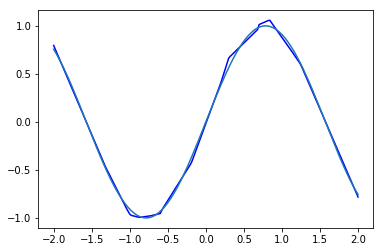

In [27]:
NN = DogikoLearn()
NN.r_square_regularizer(0.000001)
NN.set_training_data(X, Y)
NN.set_validation_data(X, Y)
NN.add_layer(Layer(30, Relu()))
NN.add_layer(Layer(1,Identity()))
NN.build()

NN.train(100, descent_method="Rprop")

plt.plot(X.reshape((201)), NN.py.reshape((201)), "b", X.reshape((201)), Y.reshape((201)))
plt.show()

# Example 2

Net-shape classification

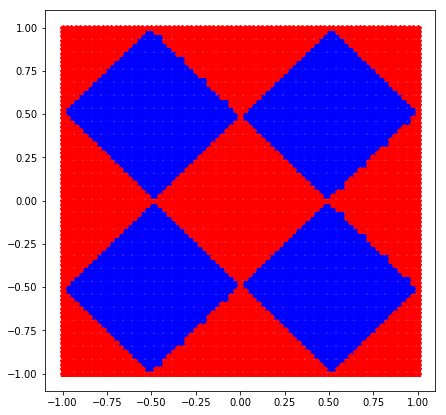

In [28]:
X = np.array([np.arange(81).repeat(81), np.arange(81*81) % 81]).astype(np.float64)
X -= 40.
X /= 40.
Y_temp = (((X[0] + X[1] - 0.5) % 2.) > 1.) ^ (((X[0] - X[1] - 0.5) % 2.) > 1.)
Y = np.zeros(Y_temp.shape + (2,))
Y[:,0] = Y_temp.astype(np.float64)
Y[:,1] = 1 - Y[:,0]
X = X.T

plt.figure(figsize=(7,7))
plt.plot(X.T[0][Y[:,0]==1], X.T[1][Y[:,0]==1], "bp")
plt.plot(X.T[0][Y[:,1]==1], X.T[1][Y[:,1]==1], "rp")
plt.show()

In [29]:
permu = np.random.permutation(np.arange(81*81))

X_train = X[permu[:5000]]
Y_train = Y[permu[:5000]]
X_valid = X[permu[5000:]]
Y_valid = Y[permu[5000:]]

NN = DogikoLearn(loss_function="ce")
NN.rs_extend_regularizer(0.001,3.)
NN.set_training_data(X_train, Y_train)
NN.set_validation_data(X_valid, Y_valid)
NN.add_layer(Layer(10, Hypertan()))
NN.add_layer(Layer(10, Hypertan()))
NN.add_layer(Layer(2, Softmax()))
NN.build()

In [31]:
for t in range(20):
    """
    permu = np.random.permutation(np.arange(81*81))
    X_train = X[permu[:5000]]
    Y_train = Y[permu[:5000]]
    X_valid = X[permu[5000:]]
    Y_valid = Y[permu[5000:]]
    NN.set_training_data(X_train, Y_train)
    NN.set_validation_data(X_valid, Y_valid)
    """
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, 1, 0.01/NN.ly[l+1].dimension())
    
    print(NN.train(1000, descent_method="Rprop", termination=[10,30,0.]))
    
    #dr = NN.dimension()/NN.tx.shape[0]
    #er = max(1., NN.validation_error()/NN.training_error())
    
    for l in range(NN.ln-1):
        NN.neuron_refined(l, X_valid, -15)
        print(NN.ly[l].nn, end=", ")
    
    print(NN.train(1000, descent_method="Rprop", termination=[10,30,0.]))
    
    print(round(NN.training_error(), 3),
          round(NN.validation_error(), 3),
          round((NN.prediction(NN.vx).argmax(axis=1) == NN.vy.argmax(axis=1)).sum()/NN.vy.shape[0], 3)
         )

print("down")

59
15, 15, 61
0.053 0.071 0.977
32
15, 15, 86
0.051 0.067 0.983
52
15, 15, 75
0.05 0.064 0.98
57
15, 15, 148
0.046 0.056 0.983
48
15, 15, 54
0.05 0.066 0.976
105
15, 15, 70
0.042 0.054 0.985
31
15, 15, 48
0.041 0.055 0.985
59
15, 15, 92
0.04 0.052 0.984
37
15, 15, 48
0.04 0.055 0.98
64
15, 15, 59
0.038 0.053 0.983
81
15, 15, 46
0.047 0.057 0.978
75
15, 15, 77
0.039 0.052 0.985
42
15, 15, 62
0.038 0.049 0.986
33
15, 15, 62
0.036 0.048 0.987
92
15, 15, 72
0.034 0.044 0.989
36
15, 15, 127
0.031 0.043 0.99
33
15, 15, 119
0.031 0.046 0.987
46
15, 15, 61
0.034 0.046 0.987
34
15, 15, 99
0.03 0.043 0.986
51
15, 15, 93
0.03 0.043 0.986
down


In [13]:
NN.training_accuracy()

0.99680000000000002

In [97]:
NN.validation_error()

0.044689872293273848

In [96]:
NN.identity_dig(2, Hypertan())

9, 16, 13, 436 0.01 0.022
9, 17, 13, 459 0.008 0.024
8, 15, 10, 341 0.014 0.022
8, 16, 11, 379 0.009 0.02
8, 17, 12, 419 0.008 0.02
8, 18, 13, 461 0.006 0.022
7, 13, 12, 319 0.018 0.03
7, 14, 13, 356 0.011 0.023
7, 15, 14, 395 0.01 0.021
7, 16, 15, 436 0.008 0.026


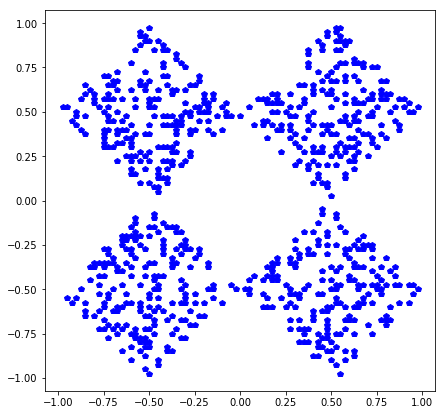

In [98]:
NN.train(500, descent_method="Rprop")
dr = NN.dimension()/NN.tx.shape[0]
er = max(1., NN.validation_error()/NN.training_error())
NN.neuron_refined(NN.ln-2, X_valid, min(1., (er**3)*(dr**3))/(NN.ly[NN.ln-2].nn))

for t in range(10):
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, 1, 0.01/NN.ly[l+1].dimension())

    NN.train(500, descent_method="Rprop")
    
    dr = NN.dimension()/NN.tx.shape[0]
    er = max(1., NN.validation_error()/NN.training_error())
    
    for l in range(NN.ln-1):
        NN.neuron_refined(l, X_valid, min(1., (er**3)*(dr**3))/(NN.ly[l].nn))
        print(NN.ly[l].nn, end=", ")
    
    NN.train(500, descent_method="Rprop")
    
    print(NN.dimension(), round(NN.training_error(), 3), round(NN.validation_error(), 3))

NN.prediction(X_valid)
plt.figure(figsize=(7,7))
plt.plot(X_valid.T[0][NN.py[:,0]>0.5], X_valid.T[1][NN.py[:,0]>0.5], "bp")
plt.show()

In [86]:
accuracys_t = np.zeros((100))
accuracys_v = np.zeros((100))
for t in range(100):
    NN = DogikoLearn(loss_function="ce")
    NN.rs_extend_regularizer(0.001,3.)
    NN.set_training_data(X_train, Y_train)
    NN.set_validation_data(X_valid, Y_valid)
    NN.add_layer(Layer(10,LeakyRelu()))
    NN.add_layer(Layer(10,LeakyRelu()))
    NN.add_layer(Layer(2,Softmax()))
    NN.build()
    
    NN.train(1000, descent_method="Rprop")
    
    accuracys_t[t] = NN.training_error()
    accuracys_v[t] = NN.validation_error()
    
    if (t+1) % 5 ==0:
        print(t+1)

print("done")

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
done


In [87]:
accuracys_t.sort()
accuracys_t = np.round(accuracys_t, 3)
print(accuracys_t)
print(accuracys_t.min(), accuracys_t[25], accuracys_t[50], accuracys_t[75], accuracys_t.max())

[ 0.055  0.058  0.058  0.067  0.069  0.071  0.072  0.075  0.076  0.076
  0.077  0.079  0.079  0.079  0.08   0.08   0.081  0.081  0.082  0.083
  0.084  0.084  0.084  0.085  0.085  0.086  0.087  0.087  0.087  0.088
  0.088  0.088  0.089  0.089  0.089  0.09   0.09   0.09   0.091  0.092
  0.093  0.094  0.094  0.095  0.095  0.096  0.097  0.098  0.098  0.098
  0.099  0.099  0.099  0.101  0.102  0.102  0.102  0.103  0.103  0.104
  0.104  0.104  0.104  0.105  0.105  0.107  0.108  0.108  0.109  0.111
  0.112  0.113  0.115  0.118  0.119  0.119  0.12   0.12   0.125  0.127
  0.127  0.128  0.129  0.131  0.131  0.132  0.133  0.133  0.134  0.134
  0.137  0.137  0.138  0.141  0.149  0.174  0.206  0.327  0.384  0.441]
0.055 0.086 0.099 0.119 0.441


In [88]:
accuracys_v.sort()
accuracys_v = np.round(accuracys_v, 3)
print(accuracys_v)
print(accuracys_v.min(), accuracys_v[25], accuracys_v[50], accuracys_v[75], accuracys_v.max())

[ 0.057  0.061  0.063  0.071  0.071  0.072  0.074  0.078  0.078  0.078
  0.08   0.081  0.082  0.082  0.082  0.083  0.083  0.084  0.085  0.087
  0.087  0.087  0.088  0.088  0.088  0.088  0.089  0.089  0.089  0.09   0.09
  0.09   0.09   0.09   0.091  0.091  0.092  0.092  0.092  0.093  0.094
  0.094  0.095  0.098  0.098  0.098  0.098  0.098  0.099  0.101  0.101
  0.102  0.103  0.103  0.103  0.105  0.106  0.106  0.107  0.107  0.107
  0.108  0.108  0.108  0.109  0.109  0.111  0.112  0.113  0.114  0.116
  0.116  0.117  0.118  0.121  0.124  0.124  0.125  0.125  0.126  0.126
  0.132  0.132  0.133  0.135  0.135  0.135  0.138  0.139  0.139  0.139
  0.142  0.146  0.148  0.152  0.18   0.207  0.342  0.396  0.461]
0.057 0.088 0.101 0.124 0.461


In [89]:
NN.dimension()

162

In [75]:
NN.validation_error()
for i in range(NN.ln-1):
    for j in range(i+1, NN.ln):
        rr = NN.inter_layer_linear_regression((i,j))
        print(i, j, rr[0].shape, (rr[1].sum()/(NN.ly[j].x.var(axis=1).sum()+0.01)))

0 1 (3, 10) 0.0789749677881
0 2 (3, 10) 0.151427476744
0 3 (3, 2) 0.128019887719
1 2 (11, 10) 0.0163064692087
1 3 (11, 2) 0.0221946229495
2 3 (11, 2) 0.00461351269551


# Examlple 3
Linear case 

In [12]:
X = np.random.normal(0,1, (10000, 5))

In [13]:
A = np.random.normal(0,1, (5,5))
while np.linalg.det(A) < 0.5:
    A = np.random.normal(0,1, (5,5))

In [14]:
Y = np.dot(X,A)

In [15]:
NN = DogikoLearn(loss_function="r2")
NN.rs_extend_regularizer(0.001,10.)
NN.set_training_data(X, Y)
NN.set_validation_data(X, Y)
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(50,LeakyRelu()))
NN.add_layer(Layer(5,Identity()))
NN.build()

In [16]:
for t in range(20):
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, int(0.1*NN.ly[l].nn) + 1)

    for i in range(100):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.0001:
            break

    for l in range(NN.ln-1):
        NN.neuron_refined(l, X,((NN.dimension()/(10000))**2)/(NN.ly[l].nn))
        print(NN.ly[l].nn, end=", ")

    for i in range(100):
        NN.batch_fit(X,Y,step=0.1, descent_method="Rprop")
        if NN.max_cs < 0.0001:
            break

    print(NN.validate())

9, 12, 27, 0.0493435386694
9, 9, 12, 0.0113445106801
10, 8, 12, 0.00755824874162
10, 8, 10, 0.00444346400938
10, 9, 10, 0.00263462290757
12, 9, 10, 0.000664910727598
9, 8, 8, 0.00237638763757
8, 8, 7, 0.00076685471248
7, 8, 7, 0.00224576035833
7, 8, 8, 0.00104895855289
7, 7, 7, 0.00155323345726
8, 7, 7, 0.000591984296887
7, 7, 6, 8.92301498747e-05
6, 7, 7, 0.00106030334232
7, 8, 7, 0.000243928801053
7, 8, 7, 0.000579466981622
7, 6, 6, 0.00053306100836
6, 6, 6, 0.00145979593393
6, 7, 6, 0.000504371044989
7, 7, 6, 0.000187245110848


In [64]:
for i in range(100):
    NN.batch_fit(X,Y,step=0.5, descent_method="Rprop")

In [65]:
for l in range(NN.ln-1):
    print(NN.ly[l].nn, end= ", ")
    NN.neuron_refined(l, None, 0.0001)
    print(NN.ly[l].nn)

10, 10


In [18]:
for i in range(NN.ln-1):
    for j in range(i+1, NN.ln):
        rr = NN.inter_layer_linear_regression((i,j))
        print(i, j, np.sqrt(rr[1].sum()))

0 1 1.97488787516
0 2 0.198389442508
0 3 0.0773856446697
1 2 0.0856913391978
1 3 0.0664770708499
2 3 0.0453495495103


# MNIST

In [2]:
from mnist import MNIST

In [18]:
mnistloader = MNIST("../python-mnist/data/")
training_data = mnistloader.load_training()
X = np.array(training_data[0])
X = (2*X/255) - 1. # to [-1, +1]

Y = np.zeros((60000, 10))
for i in range(Y.shape[0]):
    Y[i][training_data[1][i]] = 1.

testing_data = mnistloader.load_testing()
X_test = np.array(testing_data[0])
X_test = (2*X_test/255) - 1. # to [-1, +1]

Y_test = np.zeros((10000, 10))
for i in range(Y_test.shape[0]):
    Y_test[i][testing_data[1][i]] = 1.

In [6]:
shuffle = np.random.permutation(60000)
X_train = X[shuffle[:56000]]
Y_train = Y[shuffle[:56000]]
X_valid = X[shuffle[56000:]]
Y_valid = Y[shuffle[56000:]]

In [7]:
NN = DogikoLearn(loss_function="ce")
NN.rs_extend_regularizer(0.001, 5.)
NN.set_training_data(X_train, Y_train)
NN.set_validation_data(X_valid, Y_valid)
NN.add_layer(Layer(300, Hypertan()))
NN.add_layer(Layer(100, Hypertan()))
NN.add_layer(Layer(10, Softmax()))
NN.build()

In [8]:
NN.load_weight("MNIST-model-300-100-hu/")

In [26]:
for t in range(1):
    shuffle = np.random.permutation(60000)
    X_train = X[shuffle[:56000]]
    Y_train = Y[shuffle[:56000]]
    X_valid = X[shuffle[56000:]]
    Y_valid = Y[shuffle[56000:]]
    NN.set_training_data(X_train, Y_train)
    NN.set_validation_data(X_valid, Y_valid)
    
    for l in range(NN.ln-1):
        NN.neuron_proliferate(l, 10, 0.01/NN.ly[l+1].dimension())
    
    NN.reset_cs(0.01)
    NN.train(500, descent_method="Rprop")
    
    NN.neuron_refined(0, X, -300)
    NN.neuron_refined(1, X, -100)
    for l in range(NN.ln-1):
        print(NN.ly[l].nn, end=", ")
    
    NN.reset_cs(0.01)
    NN.train(300, descent_method="Rprop")
    
    print(round(NN.training_error(), 5),
          round(NN.validation_error(), 5),
          ((NN.prediction(NN.vx).argmax(axis=1) == np.array(training_data[1])[shuffle[56000:]]).sum())/NN.vx.shape[0]
         )

300, 100, 0.16583 0.54442 0.9275


In [30]:
NN.save_weight("MNIST-model-300-100-hu/")

In [27]:
((NN.prediction(NN.vx).argmax(axis=1) == np.array(training_data[1])[shuffle[56000:]]).sum())/NN.vx.shape[0]

0.92749999999999999

In [28]:
((NN.prediction(X_test).argmax(axis=1) == np.array(testing_data[1])).sum())/X_test.shape[0]

0.92500000000000004

In [26]:
mnistloader = MNIST("../python-mnist/data/")
training_data = mnistloader.load_training()
X = np.array(training_data[0])


In [28]:
text_file = open("/Users/dogiko/Documents/mnist_train_data.txt", "w")
for l in range(X.shape[0]):
    temp_string = ""
    for c in range(784):
        temp_string += str(X[l][c]).zfill(3)
    text_file.write(temp_string + "\n")

text_file.close()

In [30]:
X.shape

(60000, 784)

# Save mnist as txt.

In [3]:
from mnist import MNIST

In [6]:
mnistloader = MNIST("../python-mnist/data/")
training_data = mnistloader.load_training()
X_train = np.array(training_data[0])

Y_train = np.zeros((X_train.shape[0], 10))
for i in range(Y_train.shape[0]):
    Y_train[i][training_data[1][i]] = 1

testing_data = mnistloader.load_testing()
X_test = np.array(testing_data[0])

Y_test = np.zeros((X_test.shape[0], 10))
for i in range(Y_test.shape[0]):
    Y_test[i][testing_data[1][i]] = 1

X_train = X_train.astype(int)
Y_train = Y_train.astype(int)
X_test = X_test.astype(int)
Y_test = Y_test.astype(int)

In [7]:
np.save("mnist-npy/train_data.npy", X_train)
np.save("mnist-npy/train_label.npy", Y_train)
np.save("mnist-npy/test_data.npy", X_test)
np.save("mnist-npy/test_label.npy", Y_test)

In [48]:
# training data to txt
text_file = open("/Users/dogiko/Documents/mnist_txt/train_data.txt", "w")
for i in range(X_train.shape[0]):
    temp_string = ""
    for j in range(784):
        temp_string += str(X_train[i][j]).zfill(3)
    
    text_file.write(temp_string + "\n")

text_file.close()


# training label to txt
text_file = open("/Users/dogiko/Documents/mnist_txt/train_label.txt", "w")
for i in range(Y_train.shape[0]):
    temp_string = ""
    for j in range(10):
        temp_string += str(Y_train[i][j])
    
    text_file.write(temp_string + "\n")

text_file.close()


# testing data to txt
text_file = open("/Users/dogiko/Documents/mnist_txt/test_data.txt", "w")
for i in range(X_test.shape[0]):
    temp_string = ""
    for j in range(784):
        temp_string += str(X_test[i][j]).zfill(3)
    
    text_file.write(temp_string + "\n")

text_file.close()


# testing label to txt
text_file = open("/Users/dogiko/Documents/mnist_txt/test_label.txt", "w")
for i in range(Y_test.shape[0]):
    temp_string = ""
    for j in range(10):
        temp_string += str(Y_test[i][j])
    
    text_file.write(temp_string + "\n")

text_file.close()

In [32]:
X = np.zeros((6, 10000000))
Y = np.zeros((6, 10000000))

In [94]:
X[0] = np.random.normal(0, 1, (1,10000000))
Y[0] = 2.3377270891440238*(1-1/(abs(X[0])+1))

In [95]:
for i in range(1,6):
    X[i] = X[0]**(i+1)
    Y[i] = Y[0]**(i+1)

In [96]:
X.mean(axis=1)

array([ -3.05669534e-04,   9.99658613e-01,  -6.88149692e-04,
         2.99755337e+00,  -2.13604835e-03,   1.49903271e+01])

In [97]:
Y.mean(axis=1)

array([ 0.9002696 ,  1.00007725,  1.2233404 ,  1.58797483,  2.1491513 ,
        3.00215376])

In [31]:
abs(X).max(axis=1)

array([   5.275685  ,   27.8328522 ,  146.83736082,  774.66766164])

In [46]:
myTanh.trans(2.5*np.ones(1))

array([ 0.9866143])

In [55]:
np.sqrt(2.5)

1.5811388300841898

In [93]:
np.sqrt(1/0.18298369)

2.3377270891440238

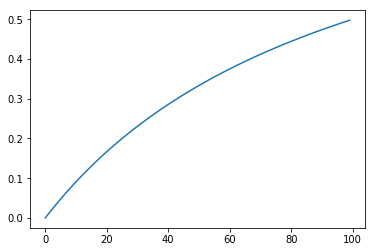

In [105]:
plt.plot(np.arange(100), 1- 1/((np.arange(100)/100)+1))
plt.show()

In [22]:
ter = (5,20,10.)

In [10]:
np.arange(20).std()

5.7662812973353983

In [5]:
foo = np.arange(20)
foo[(foo<15)&(foo>5)]=0
foo

array([ 0,  1,  2,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 16,
       17, 18, 19])